# Advanced Machine Learning Technologies
# Laboratory work № 1 
Performed by Petrov Alexander, j4134c
Dataset source, (https://www.kaggle.com/datasets/varpit94/bitcoin-data-updated-till-26jun2021)

In [1]:
import pandas as pd
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from itertools import product
from numpy import array

<ipython-input-1-b5d7028358a7>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [16]:
file_path = 'Bitcoin Historical Data.csv'
data = pd.read_csv(file_path, ',', index_col=['Date'], parse_dates=['Date'], dayfirst=True)
series_size = 1000
test_size = series_size//5
data = data.iloc[:series_size]
data = data[['Price']]
data = data.iloc[::-1]

for i in range(len(data)):
    data['Price'][i] = data['Price'][i].replace(',', '')
data['Price'] = data['Price'].astype('float')
data_for_lstm = data

In [17]:
prices_list = data.values.squeeze()
days_points = np.arange(0, series_size)

# data spliting
prices_train = prices_list[:series_size - test_size]
prices_test = prices_list[series_size - test_size:]

days_train_points = days_points[:series_size - test_size]
days_test_points = days_points[series_size - test_size:]

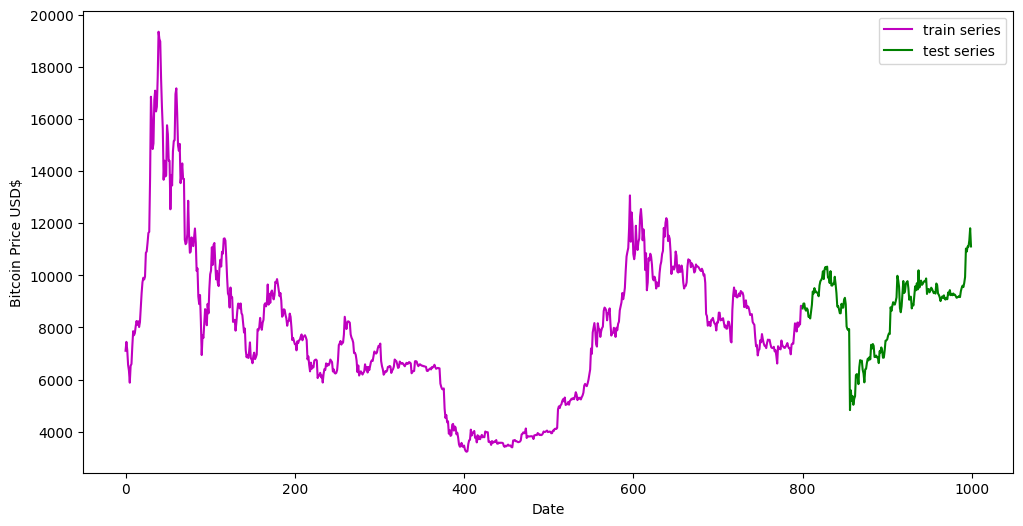

In [18]:
plt.figure(figsize = (12,6))
plt.plot(days_train_points, prices_train, linewidth=1.5, color = 'm', label='train series')
plt.plot(days_test_points, prices_test, linewidth=1.5, color = 'g', label='test series')
plt.ylabel('Bitcoin Price USD$')
plt.xlabel('Date')
plt.legend()
plt.show()

Best Boc Cox parameter: 0.268607
Dickey-Fuller test: p=0.455842


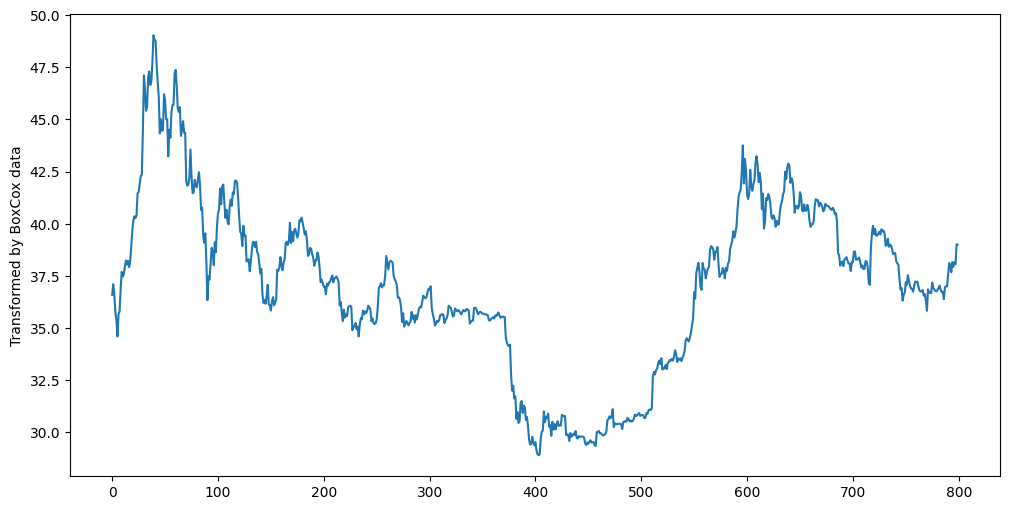

In [19]:
prices_list_boxcox, lmbda = stats.boxcox(prices_train)
plt.figure(figsize=(12, 6))
plt.plot(days_train_points, prices_list_boxcox, linewidth=1.5)
plt.ylabel('Transformed by BoxCox data')
print('Best Boc Cox parameter: %f' % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(prices_list_boxcox)[1])

In [20]:
ps = range(0, 6)   # 5
d = 1
qs = range(0, 6)  # 5
Ps = range(0, 2)  # 1
D = 1
Qs = range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


In [21]:
import warnings
results = []
best_aic = float("inf")

# ignore warnings
warnings.filterwarnings('ignore')

for param in parameters_list:

    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(prices_list_boxcox, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 30)).fit(disp=-1)

    #print wrong parameters and go on
    # AIC criteria:
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

     parameters          aic
1  (0, 0, 1, 0)  1381.972931
0  (0, 0, 0, 0)  1576.790971
     parameters          aic
1  (0, 0, 1, 0)  1381.972931
0  (0, 0, 0, 0)  1576.790971
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  800
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 30)   Log Likelihood                -688.986
Date:                            Tue, 19 Sep 2023   AIC                           1381.973
Time:                                    13:01:29   BIC                           1391.263
Sample:                                         0   HQIC                          1385.548
                                            - 800                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

In [22]:
pred_arima = invboxcox(best_model.predict(start=len(prices_train), end=len(prices_train) + len(prices_test) - 1), lmbda)

# ARIMA forecasting

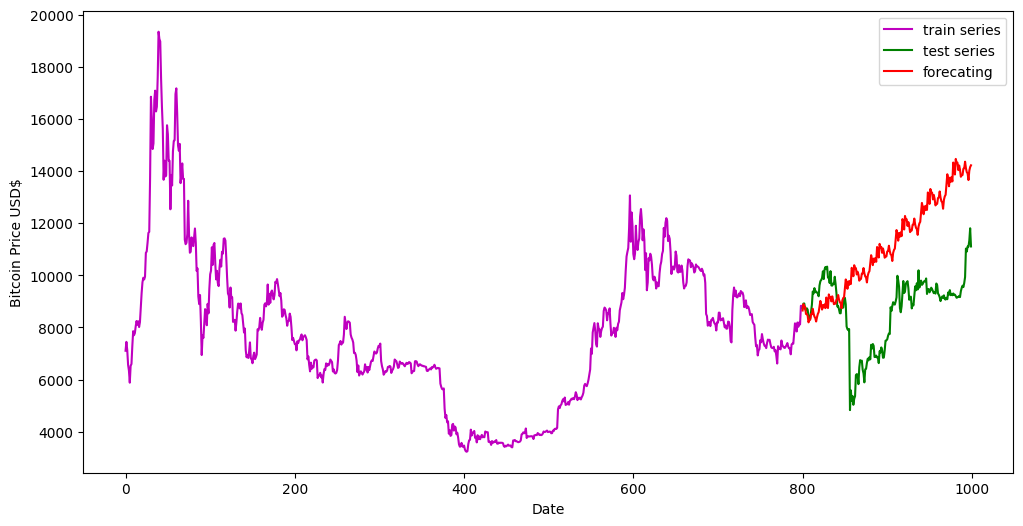

In [23]:
plt.figure(figsize = (12,6))
plt.plot(days_train_points, prices_train, linewidth=1.5, color = 'm', label='train series')
plt.plot(days_test_points, prices_test, linewidth=1.5, color = 'g', label='test series')
plt.plot(days_test_points, pred_arima, linewidth=1.5, color='r', label='forecating')
plt.ylabel('Bitcoin Price USD$')
plt.xlabel('Date')
plt.legend()
plt.show()

# ARIMA quality metrics (R2 and MAPE)

In [24]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
print(f'R2 = {round(r2_score(y_true=prices_test, y_pred=pred_arima), 5)},\nMAPE = {round(mean_absolute_percentage_error(y_true=prices_test, y_pred=pred_arima), 5)}')

R2 = -4.21138,
MAPE = 0.33037


# LSTM model

In [25]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()

    # stateful = True - keep state in memory;

    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss

# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

#  inverse_difference
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

In [26]:
data_train_lstm = data_for_lstm[:series_size - test_size]

In [20]:
d1 = series_to_supervised(data_train_lstm, n_in = 12, n_out = 6, dropnan = True)
d1

,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
Date,,,,,,,,,,,,,,,,,,
2019-04-03,3990.4,4002.5,3994.7,3937.0,3942.8,4041.7,4025.6,4102.2,4111.8,4102.3,4145.1,4859.3,4968.7,4902.4,5010.2,5046.2,5173.6,5245.2
2019-04-04,4002.5,3994.7,3937.0,3942.8,4041.7,4025.6,4102.2,4111.8,4102.3,4145.1,4859.3,4968.7,4902.4,5010.2,5046.2,5173.6,5245.2,5158.4
2019-04-05,3994.7,3937.0,3942.8,4041.7,4025.6,4102.2,4111.8,4102.3,4145.1,4859.3,4968.7,4902.4,5010.2,5046.2,5173.6,5245.2,5158.4,5307.8
2019-04-06,3937.0,3942.8,4041.7,4025.6,4102.2,4111.8,4102.3,4145.1,4859.3,4968.7,4902.4,5010.2,5046.2,5173.6,5245.2,5158.4,5307.8,5022.6
2019-04-07,3942.8,4041.7,4025.6,4102.2,4111.8,4102.3,4145.1,4859.3,4968.7,4902.4,5010.2,5046.2,5173.6,5245.2,5158.4,5307.8,5022.6,5054.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-15,6735.9,6857.4,6772.7,7332.3,7185.2,7361.2,7289.0,6863.1,6867.8,6917.6,6841.3,6850.9,6629.1,7085.6,7035.8,7230.8,7122.9,6833.5
2020-04-16,6857.4,6772.7,7332.3,7185.2,7361.2,7289.0,6863.1,6867.8,6917.6,6841.3,6850.9,6629.1,7085.6,7035.8,7230.8,7122.9,6833.5,6842.5
2020-04-17,6772.7,7332.3,7185.2,7361.2,7289.0,6863.1,6867.8,6917.6,6841.3,6850.9,6629.1,7085.6,7035.8,7230.8,7122.9,6833.5,6842.5,7112.9


In [27]:
# historical lag - multiple of 12 - length of the input vector
n_lag = 48   # 24, 36
# forecasting period
n_seq = 200
# number of test samples
n_test = 64
# number of epochs for training
n_epochs = 30
# batch size
n_batch = 1
# number of LSTM cells
n_neurons =  12

# dataset preparation
scaler, train, test = prepare_data(data_train_lstm, n_test, n_lag, n_seq)
# train the model
model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts for n_seq steps
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse scaling
forecasts = inverse_transform(data_train_lstm, forecasts, scaler, n_test+2)

0
439/439 [==============================] - 8s 4ms/step - loss: 0.0129 - val_loss: 0.0219
1
439/439 [==============================] - 2s 4ms/step - loss: 0.0102 - val_loss: 0.0219
2
439/439 [==============================] - 2s 4ms/step - loss: 0.0100 - val_loss: 0.0219
3
439/439 [==============================] - 2s 4ms/step - loss: 0.0100 - val_loss: 0.0219
4
439/439 [==============================] - 2s 3ms/step - loss: 0.0099 - val_loss: 0.0219
5
439/439 [==============================] - 2s 4ms/step - loss: 0.0099 - val_loss: 0.0219
6
439/439 [==============================] - 2s 4ms/step - loss: 0.0099 - val_loss: 0.0219
7
439/439 [==============================] - 2s 5ms/step - loss: 0.0098 - val_loss: 0.0219
8
439/439 [==============================] - 2s 4ms/step - loss: 0.0098 - val_loss: 0.0219
9
439/439 [==============================] - 2s 4ms/step - loss: 0.0097 - val_loss: 0.0219
10
439/439 [==============================] - 2s 4ms/step - loss: 0.0097 - val_loss: 0.021

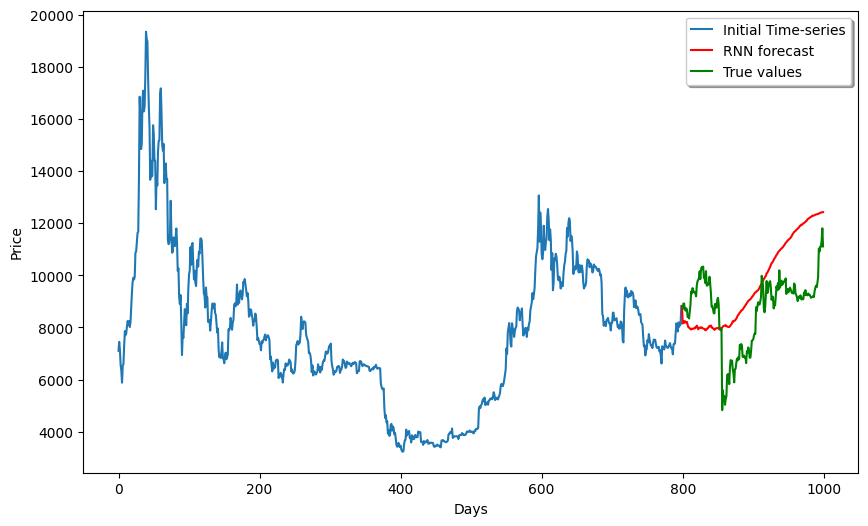

In [28]:
fig=plt.figure(figsize=(10,6))

plt.plot(data_train_lstm.values[:], linewidth=1.5)

off_s = len(data_train_lstm) - n_test +len(forecasts)  - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
lstm_forecast = [data_train_lstm.values[off_s]] + forecasts[-1]

plt.plot(xaxis, lstm_forecast, color='r',linewidth=1.5)

plt.plot(xaxis[1:], prices_test, color='g', linewidth=1.5)

plt.ylabel('Price')
plt.xlabel('Days')

plt.legend(('Initial Time-series', 'RNN forecast', 'True values'), shadow=True, handlelength=1.5, fontsize=10)
plt.show()

# LSTM model quality metrics

In [30]:
print(f'R2 = {round(r2_score(y_true=prices_test, y_pred=lstm_forecast[:200]), 5)},\nMAPE = {round(mean_absolute_percentage_error(y_true=prices_test, y_pred=lstm_forecast[:200]), 5)}')

R2 = -0.83113,
MAPE = 0.19586


# Summary graphs

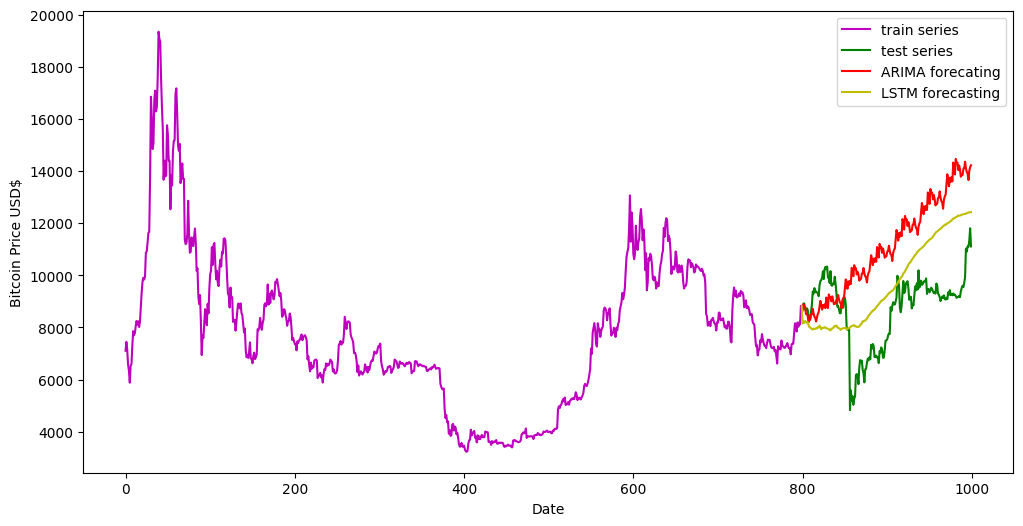

In [31]:
plt.figure(figsize = (12,6))
plt.plot(days_train_points, prices_train, linewidth=1.5, color = 'm', label='train series')
plt.plot(days_test_points, prices_test, linewidth=1.5, color = 'g', label='test series')
plt.plot(days_test_points, pred_arima, linewidth=1.5, color='r', label='ARIMA forecating')
plt.plot(xaxis, lstm_forecast, color='y',linewidth=1.5, label='LSTM forecasting')

plt.ylabel('Bitcoin Price USD$')
plt.xlabel('Date')
plt.legend()
plt.show()

# Conclusion
Finnaly we have built two models for forecasting time series data (ARIMA and LSTM models).

"Bitcoin History Data" from Kaggle was used as dataset for this lab.
As one can see from obtained graphs and metrics (R2 and MAPE) we can conclude that LSTM model has a better performance for choosen dataset than ARIMA model.